In [4]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [10]:
task = pd.read_csv("sign-up.csv")
task.head()

,participant_id,condition,reaction_time,major_errors,minor_erros,clicks,ease,confidence,flexibility_importance,group
0,2,A,16174,0,0,5,7,7,6,0
1,2,B,44145,0,0,13,7,7,2,0
2,3,A,22847,0,0,5,7,7,6,0
3,3,B,41568,0,0,15,7,7,5,0
4,12,A,87229,2,2,30,7,7,7,0


In [11]:
task["condition"] = task["condition"].astype("category")
task.dtypes

participant_id               int64
condition                 category
reaction_time                int64
major_errors                 int64
minor_erros                  int64
clicks                       int64
ease                         int64
confidence                   int64
flexibility_importance       int64
group                        int64
dtype: object

In [12]:
def order_effect_check(df, dv, group_col="group",
                       id_col="participant_id", cond_col="condition",
                       a="A", b="B", title=None):
    title = title or dv

    wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean").reset_index()
    groups = df[[id_col, group_col]].drop_duplicates(id_col)
    wide = wide.merge(groups, on=id_col, how="left")
    wide = wide.dropna(subset=[a, b])

    wide["diff_A_minus_B"] = wide[a] - wide[b]

    g0 = wide.loc[wide[group_col] == 0, "diff_A_minus_B"]
    g1 = wide.loc[wide[group_col] == 1, "diff_A_minus_B"]

    print(f"\n=== Order effect: {title} ===")
    print("n group0 =", len(g0), "n group1 =", len(g1))
    print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

    t, p = stats.ttest_ind(g0, g1, equal_var=False)  # Welch
    print(f"Welch t-test on diffs: t = {t:.3f}, p = {p:.4f}")

    # Plot: diffs by order group
    plt.figure()
    plt.boxplot([g0.dropna(), g1.dropna()], labels=["group0 (A first)", "group1 (B first)"])
    plt.title(f"{title}: differences (A-B) by order group")
    plt.ylabel(f"{a}-{b}")
    plt.show()

    return wide

## order effect check

reaction_time

In [13]:

wide = task.pivot_table(
    index="participant_id",
    columns="condition",
    values="reaction_time",
    aggfunc="mean"
).reset_index()

groups = task[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 7363.428571428572 mean diff group1 = -58115.2
order effect on diff (Welch): t = 0.42960399045017716 p = 0.6885709955119588


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/1762851895.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = task.pivot_table(



=== Order effect: AddPlant: Reaction Time (ms) ===
n group0 = 7 n group1 = 5
mean diff group0 = 7363.428571428572 mean diff group1 = -58115.2
Welch t-test on diffs: t = 0.430, p = 0.6886


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean").reset_index()
/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0.dropna(), g1.dropna()], labels=["group0 (A first)", "group1 (B first)"])


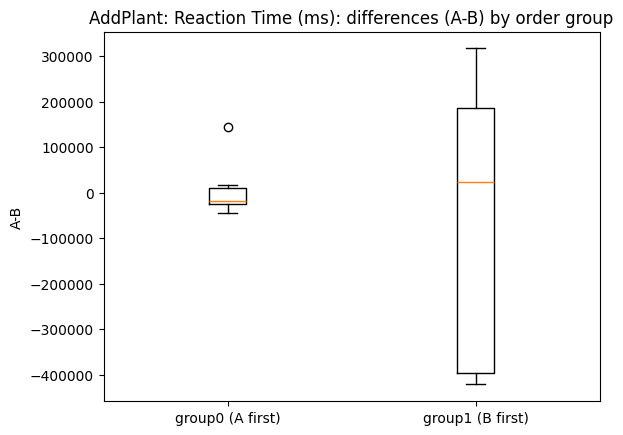

,participant_id,A,B,group,diff_A_minus_B
0,1,180200.0,35048.0,0,145152.0
1,2,16174.0,44145.0,0,-27971.0
2,3,22847.0,41568.0,0,-18721.0
3,4,9962.0,55583.0,0,-45621.0
4,5,37995.0,33326.0,0,4669.0
5,6,55927.0,31843.0,1,24084.0
6,7,279095.0,675027.0,1,-395932.0
7,8,648383.0,331616.0,1,316767.0
8,9,210457.0,631793.0,1,-421336.0
9,10,517363.0,331522.0,1,185841.0


In [14]:
order_effect_check(task, "reaction_time", title="AddPlant: Reaction Time (ms)")

errors

In [15]:
task["errors"] = task["major_errors"] + (task["minor_erros"] / 2)

wide = task.pivot_table(
    index="participant_id",
    columns="condition",
    values="errors",
    aggfunc="mean"
).reset_index()

groups = task[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 0.5 mean diff group1 = 0.2
order effect on diff (Welch): t = 0.6416889479197478 p = 0.5382684240631246


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/3387237276.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = task.pivot_table(



=== Order effect: sign-up: errors ===
n group0 = 7 n group1 = 5
mean diff group0 = 0.5 mean diff group1 = 0.2
Welch t-test on diffs: t = 0.642, p = 0.5383


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean").reset_index()
/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0.dropna(), g1.dropna()], labels=["group0 (A first)", "group1 (B first)"])


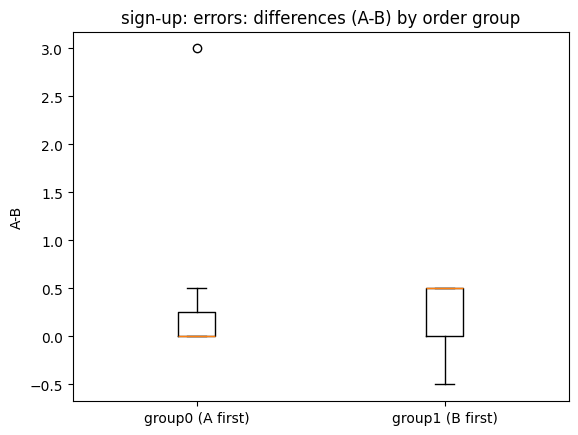

,participant_id,A,B,group,diff_A_minus_B
0,1,0.5,0.0,0,0.5
1,2,0.0,0.0,0,0.0
2,3,0.0,0.0,0,0.0
3,4,0.0,0.0,0,0.0
4,5,0.0,0.0,0,0.0
5,6,0.5,0.0,1,0.5
6,7,3.0,3.0,1,0.0
7,8,2.0,1.5,1,0.5
8,9,2.0,2.5,1,-0.5
9,10,2.5,2.0,1,0.5


In [20]:
order_effect_check(task, "errors", title="sign-up: errors")

clicks

In [16]:
wide = task.pivot_table(
    index="participant_id",
    columns="condition",
    values="clicks",
    aggfunc="mean"
).reset_index()

groups = task[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = -3.2857142857142856 mean diff group1 = -7.6
order effect on diff (Welch): t = 0.8377992517429519 p = 0.4238552237458826


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/3260844079.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = task.pivot_table(



=== Order effect: sign-up: clicks ===
n group0 = 7 n group1 = 5
mean diff group0 = -3.2857142857142856 mean diff group1 = -7.6
Welch t-test on diffs: t = 0.838, p = 0.4239


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean").reset_index()
/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0.dropna(), g1.dropna()], labels=["group0 (A first)", "group1 (B first)"])


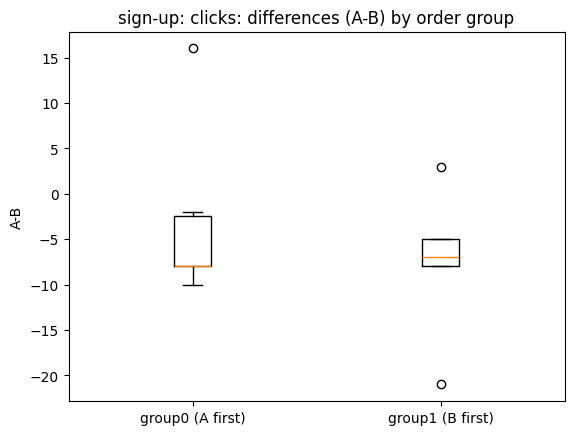

,participant_id,A,B,group,diff_A_minus_B
0,1,12.0,15.0,0,-3.0
1,2,5.0,13.0,0,-8.0
2,3,5.0,15.0,0,-10.0
3,4,5.0,13.0,0,-8.0
4,5,5.0,13.0,0,-8.0
5,6,5.0,13.0,1,-8.0
6,7,12.0,33.0,1,-21.0
7,8,15.0,12.0,1,3.0
8,9,18.0,23.0,1,-5.0
9,10,17.0,24.0,1,-7.0


In [21]:
order_effect_check(task, "clicks", title="sign-up: clicks")

ease

In [17]:
wide = task.pivot_table(
    index="participant_id",
    columns="condition",
    values="ease",
    aggfunc="mean"
).reset_index()

groups = task[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = -0.14285714285714285 mean diff group1 = 0.2
order effect on diff (Welch): t = -1.3949716649258312 p = 0.20158850527634356


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/3571434999.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = task.pivot_table(



=== Order effect: sign-up: ease ===
n group0 = 7 n group1 = 5
mean diff group0 = -0.14285714285714285 mean diff group1 = 0.2
Welch t-test on diffs: t = -1.395, p = 0.2016


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean").reset_index()
/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0.dropna(), g1.dropna()], labels=["group0 (A first)", "group1 (B first)"])


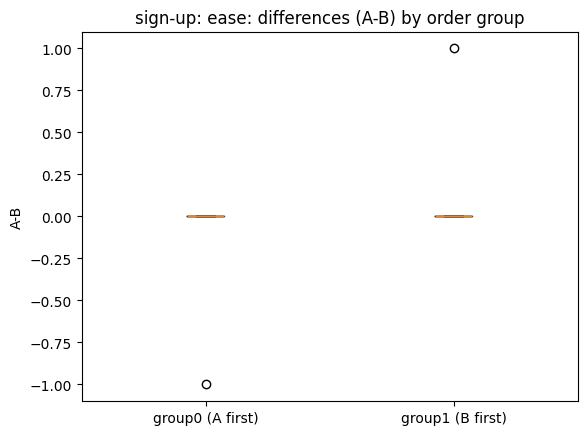

,participant_id,A,B,group,diff_A_minus_B
0,1,6.0,7.0,0,-1.0
1,2,7.0,7.0,0,0.0
2,3,7.0,7.0,0,0.0
3,4,7.0,7.0,0,0.0
4,5,7.0,7.0,0,0.0
5,6,7.0,7.0,1,0.0
6,7,7.0,7.0,1,0.0
7,8,7.0,6.0,1,1.0
8,9,7.0,7.0,1,0.0
9,10,7.0,7.0,1,0.0


In [22]:
order_effect_check(task, "ease", title="sign-up: ease")

confidence

In [18]:
wide = task.pivot_table(
    index="participant_id",
    columns="condition",
    values="confidence",
    aggfunc="mean"
).reset_index()

groups = task[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 0.0 mean diff group1 = -0.8
order effect on diff (Welch): t = 0.9299811099505542 p = 0.4050233143090605


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/633610504.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = task.pivot_table(



=== Order effect: sign-up: confidence ===
n group0 = 7 n group1 = 5
mean diff group0 = 0.0 mean diff group1 = -0.8
Welch t-test on diffs: t = 0.930, p = 0.4050


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean").reset_index()
/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0.dropna(), g1.dropna()], labels=["group0 (A first)", "group1 (B first)"])


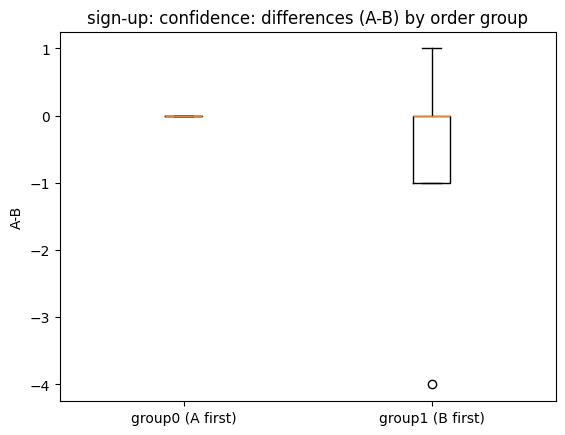

,participant_id,A,B,group,diff_A_minus_B
0,1,7.0,7.0,0,0.0
1,2,7.0,7.0,0,0.0
2,3,7.0,7.0,0,0.0
3,4,7.0,7.0,0,0.0
4,5,4.0,4.0,0,0.0
5,6,5.0,5.0,1,0.0
6,7,7.0,6.0,1,1.0
7,8,6.0,7.0,1,-1.0
8,9,7.0,7.0,1,0.0
9,10,3.0,7.0,1,-4.0


In [23]:
order_effect_check(task, "confidence", title="sign-up: confidence")

flexibility_importance

In [19]:
wide = task.pivot_table(
    index="participant_id",
    columns="condition",
    values="flexibility_importance",
    aggfunc="mean"
).reset_index()

groups = task[["participant_id", "group"]].drop_duplicates("participant_id")
wide = wide.merge(groups, on="participant_id", how="left")

wide = wide.dropna(subset=["A", "B"])

wide["diff_A_minus_B"] = wide["A"] - wide["B"]

g0 = wide.loc[wide["group"] == 0, "diff_A_minus_B"]
g1 = wide.loc[wide["group"] == 1, "diff_A_minus_B"]

print("n group0 =", len(g0), "n group1 =", len(g1))
print("mean diff group0 =", g0.mean(), "mean diff group1 =", g1.mean())

t, p = stats.ttest_ind(g0, g1, equal_var=False)
print("order effect on diff (Welch): t =", t, "p =", p)

n group0 = 7 n group1 = 5
mean diff group0 = 3.4285714285714284 mean diff group1 = -1.6
order effect on diff (Welch): t = 3.737356560434478 p = 0.004351701573123017


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/3738096086.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = task.pivot_table(



=== Order effect: sign-up: flexibility_importance ===
n group0 = 7 n group1 = 5
mean diff group0 = 3.4285714285714284 mean diff group1 = -1.6
Welch t-test on diffs: t = 3.737, p = 0.0044


/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = df.pivot_table(index=id_col, columns=cond_col, values=dv, aggfunc="mean").reset_index()
/var/folders/9f/kctrjggs22ndcx2l59bgyjy00000gn/T/ipykernel_17359/724638157.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0.dropna(), g1.dropna()], labels=["group0 (A first)", "group1 (B first)"])


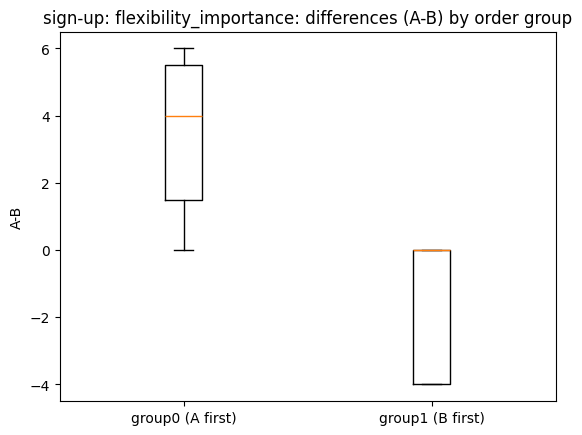

,participant_id,A,B,group,diff_A_minus_B
0,1,7.0,2.0,0,5.0
1,2,6.0,2.0,0,4.0
2,3,6.0,5.0,0,1.0
3,4,7.0,1.0,0,6.0
4,5,7.0,1.0,0,6.0
5,6,7.0,7.0,1,0.0
6,7,7.0,7.0,1,0.0
7,8,7.0,7.0,1,0.0
8,9,3.0,7.0,1,-4.0
9,10,3.0,7.0,1,-4.0


In [24]:
order_effect_check(task, "flexibility_importance", title="sign-up: flexibility_importance")